## Make plots of melt

In [1]:
import numpy as np
from pathlib import Path
from melt import glacierscene
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy import stats
from scipy import interpolate
from osgeo import gdal
import mu

data_dir = Path.home()/"GlacierSARdata"

In [2]:
def createonsetstack(gname,yearlist=[2018,2019,2020,2021],adduncertainty=False,WTKstr=None,createmeltth=False,data_dir=None):
    if WTKstr==None:
        if gname=='Wrangell': WTKstr = 'POLYGON((-144.5124 61.8108,-143.2512 61.8108,-143.2512 62.1938,-144.5124 62.1938,-144.5124 61.8108))' #Wrangell
        if gname=="Kunlun": WTKstr='POLYGON((80.1278 35.105,82.1042 35.105,82.1042 35.9315,80.1278 35.9315,80.1278 35.105))'
        if gname=="Juneau": WTKstr='POLYGON((-134.7796 58.3698,-133.5 58.3698,-133.5 59.109,-134.7796 59.109,-134.7796 58.3698))' #Juneau

    glacier = glacierscene(gname,yearlist[0],WTKstr=WTKstr,data_dir=data_dir)
    onsetstack = np.zeros((len(yearlist),glacier.imgshp[0],glacier.imgshp[1]))
    glacier.loadmask()
    gmask = glacier.gmask
    
    for i,year in enumerate(yearlist):
        print(year)
        glacier = glacierscene(gname,year,WTKstr=WTKstr,data_dir=data_dir)
        if createmeltth:
            glacier.createmeltth()
        glacier.load_meltth()
        glacier.meltonset(adduncertainty=adduncertainty)
        onsetstack[i]=glacier.meltonsetmap
    onsetstack[onsetstack==0]=np.nan
    onsetstack[:,~gmask]=np.nan
    return onsetstack,gmask

def plotimshow(inmap, region, plotname,cmap=None,vrange=None,vmethod=None,
               interp=None,dooutline=False,outlinemask=None,savecmap=False,
               addhline=False,hlx=None,hly=None,discrete=False,svfile=None):
    """used by this notebook for making nice plots"""

    if region == 'Kunlun':
        'chopping'
        inmap = inmap[900:3063,500:4950]
        if dooutline:
            outlinemask = outlinemask[900:3063,500:4950]

    ilen,jlen = np.shape(inmap)
    figscale = 150 #pix per in in height
    # sc = 1

    minilen = 1519

    fhsz = minilen/figscale
    fwsz = fhsz*jlen/ilen


    fig = plt.figure(figsize=(fwsz,fhsz))
    ax1 = fig.add_axes([.01, .01, .98, .98])
    ax=ax1.imshow(inmap)
    if vmethod == 'symmetric':
        mxmax = np.nanmax(np.abs(inmap))
        vrange = [-mxmax,mxmax]

    if vrange != None:
        ax.set_clim(vmin=vrange[0],vmax=vrange[1])
    if cmap != None:
        ax.set_cmap(cmap)

    # Hide X and Y axes label marks
    ax1.xaxis.set_tick_params(labelbottom=False)
    ax1.yaxis.set_tick_params(labelleft=False)

    if addhline:
        ax1.plot(hlx,hly,linewidth=20,color='k')
    # Hide X and Y axes tick marks
    ax1.set_xticks([])
    ax1.set_yticks([])

    if dooutline:
        plotoutline(outlinemask,ax1)
        ax1.set_position([.01, .01, .98, .98])
    if svfile != None:
        plt.savefig(svfile)

    if region=='Juneau':
        savecmap=True
    if savecmap:
        if discrete:
            cmap = plt.cm.inferno  # colormap hardcoded for now
            cmaplist = [cmap(i) for i in range(cmap.N)]

            # create the new map
            cmap = mpl.colors.LinearSegmentedColormap.from_list(
                'Custom cmap', cmaplist, cmap.N)

            # define the bins and normalize
            bounds = np.linspace(1, 8,8)
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

            ax.set_cmap(cmap)

        fig = plt.figure(figsize=(fwsz,fhsz))
        if discrete:
            ax=plt.imshow(inmap,interpolation=interp,cmap=cmap,norm=norm)
        else:
            ax=plt.imshow(inmap,interpolation=interp)
        if vmethod == 'symmetric':
            mxmax = np.nanmax(np.abs(inmap))
            vrange = [-mxmax,mxmax]

        if vrange != None:
            ax.set_clim(vmin=vrange[0],vmax=vrange[1])

        if cmap != None:
            if discrete==False:
                ax.set_cmap(cmap)

        ax1 = plt.gca()

        if discrete:
            cbar = plt.colorbar(ticks=[1.5,2.5,3.5,4.5,5.5,6.5,7.5])
            cbar.ax.set_yticklabels(['Feb.', 'Mar.', 'Apr.','May','Jun.','Jul.','Aug.'])
        else:
            cbar = plt.colorbar()

        cbar.ax.tick_params(labelsize=25)
        ax1.remove()
        plt.savefig(glacier.cwd/'figures'/'poster'/f'{plotname}_cb.png',
                    bbox_inches='tight')
        
        
def plotoutline(inmap,ax,lnwidth = 0.5):
    # mapimg = (~np.isnan(inmap))
    mapimg = inmap
    
    # a vertical line segment is needed, when the pixels next to each other horizontally
    #   belong to diffferent groups (one is part of the mask, the other isn't)
    # after this ver_seg has two arrays, one for row coordinates, the other for column coordinates 
    ver_seg = np.where(mapimg[:,1:] != mapimg[:,:-1])
    
    # the same is repeated for horizontal segments
    hor_seg = np.where(mapimg[1:,:] != mapimg[:-1,:])
    
    # if we have a horizontal segment at 7,2, it means that it must be drawn between pixels
    #   (2,7) and (2,8), i.e. from (2,8)..(3,8)
    # in order to draw a discountinuous line, we add Nones in between segments
    l = []
    for p in zip(*hor_seg):
        l.append((p[1], p[0]+1))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan,np.nan))
    
    # and the same for vertical segments
    for p in zip(*ver_seg):
        l.append((p[1]+1, p[0]))
        l.append((p[1]+1, p[0]+1))
        l.append((np.nan, np.nan))
    
    # now we transform the list into a numpy array of Nx2 shape
    segments = np.array(l)
    
    # now we need to know something about the image which is shown
    #   at this point let's assume it has extents (x0, y0)..(x1,y1) on the axis
    #   drawn with origin='lower'
    # with this information we can rescale our points
    x0,y0 = 0,0
    y1,x1 = np.shape(inmap)
    segments[:,0] = x0 + (x1-x0) * segments[:,0] / mapimg.shape[1]
    segments[:,1] = y0 + (y1-y0) * segments[:,1] / mapimg.shape[0]
    
    # and now there isn't anything else to do than plot it
    ax.plot(segments[:,0], segments[:,1], color='k', linewidth=lnwidth)

In [3]:
#Create metadata

gname = 'Wrangell'

yearlist = range(2018,2023)

if gname=='Wrangell': wrwtk = 'POLYGON((-144.5124 61.8108,-143.2512 61.8108,-143.2512 62.1938,-144.5124 62.1938,-144.5124 61.8108))' #Wrangell
if gname=="Kunlun": wrwtk='POLYGON((80.1278 35.105,82.1042 35.105,82.1042 35.9315,80.1278 35.9315,80.1278 35.105))'
if gname=="Juneau": wrwtk='POLYGON((-134.7796 58.3698,-133.5 58.3698,-133.5 59.109,-134.7796 59.109,-134.7796 58.3698))' #Juneau

createmeltthresholds=True

for year in yearlist:
    glacier = glacierscene(gname,year,data_dir=data_dir,WTKstr=wrwtk)
    if createmeltthresholds:
        glacier.createmeltth()

2018
2019
2020
2021
2022


/tmp/ipykernel_499/807028948.py:8: RuntimeWarning: Mean of empty slice
  onset = np.nanmean(onset,axis=0)


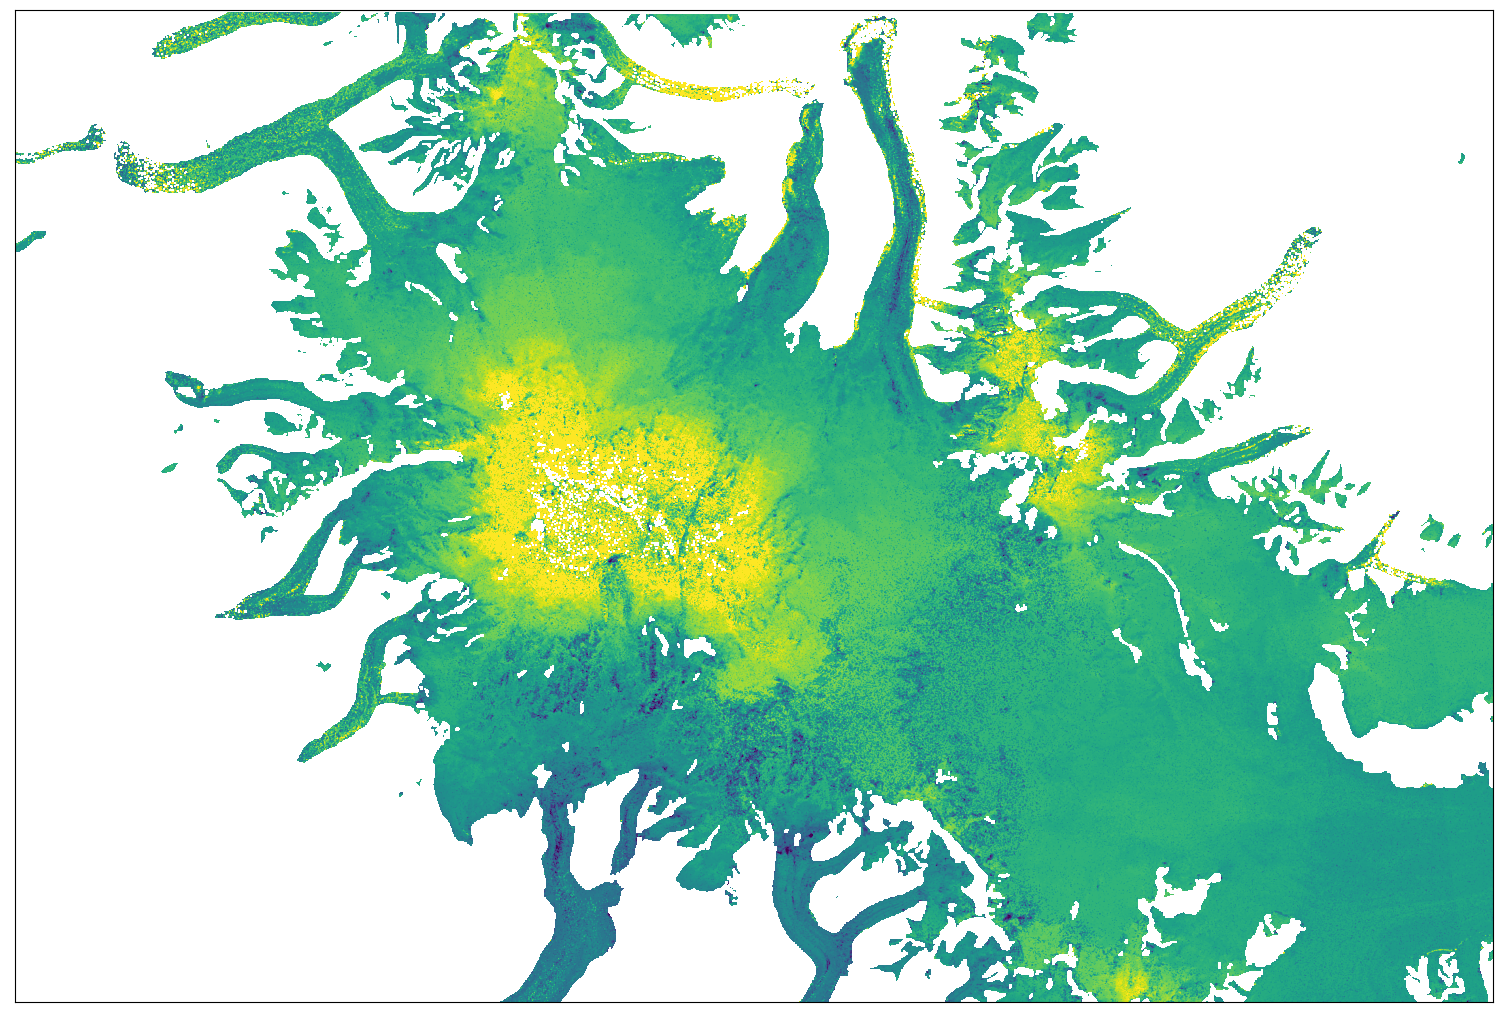

In [3]:
#Plot mean melt onset
gname = 'Wrangell'
yearlist = range(2018,2023)

onset,gmask = createonsetstack(gname,yearlist=yearlist,data_dir=data_dir)
onset[:,~gmask]=np.nan

onset = np.nanmean(onset,axis=0)


plotimshow(onset,'Wrangell','onsetmap',vrange=[50,200])

/home/jovyan/pub/GlacierSAR/melt.py:204: RuntimeWarning: invalid value encountered in divide
  weights = weights/np.sum(weights,axis=0)
/home/jovyan/pub/GlacierSAR/melt.py:204: RuntimeWarning: invalid value encountered in divide
  weights = weights/np.sum(weights,axis=0)
/tmp/ipykernel_1261/1855930696.py:26: RuntimeWarning: Mean of empty slice
  faqmap = np.nanmean(faqc,axis=0)


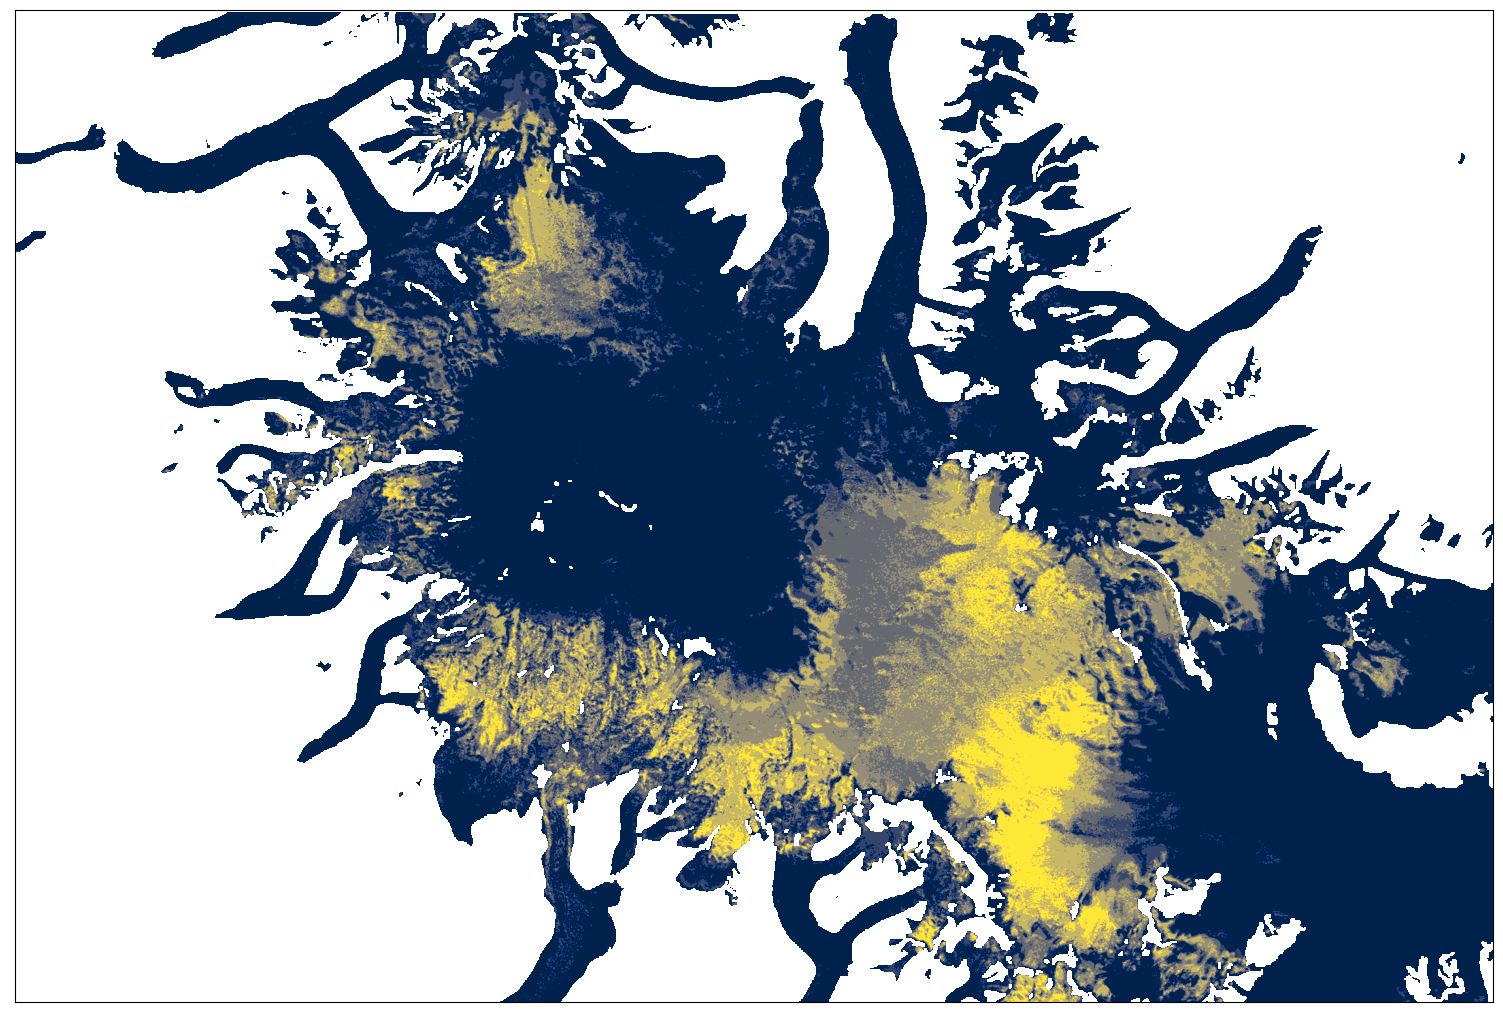

In [18]:
#firn aquifer example

gname = 'Wrangell'

yearlist = [2018,2019,2020,2021,2022]

ylen = len(yearlist)
glacier = glacierscene(gname,yearlist[0],data_dir=data_dir)

faqc = np.zeros((ylen,glacier.imgshp[0],glacier.imgshp[1]))
for i,year in enumerate(yearlist):
    glacier = glacierscene(gname,year,data_dir=data_dir)
    glacier.firnaq(firnaqth=-12)
    faqc[i] = glacier.firnaqmap

glacier.loadmask()
faqc[:,~glacier.gmask]=np.nan
faqmap = np.nanmean(faqc,axis=0)

plotimshow(faqmap, gname, 'firnaq_prob',vrange=[0,1],cmap='cividis')